<a href="https://colab.research.google.com/github/Okocha76/migration-in-europe/blob/master/Migration_In_Europe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Migration In Europe

---

## Import Data

In [0]:
%%capture
import sys

!pip install category_encoders==2.*
!pip install pandas-profiling==2.*

In [0]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Okocha76/Okocha76.github.io/master/euro_mig_data.csv', sep=';', engine='python', encoding = "ISO-8859-1")

In [0]:
print(df.shape)
df.head()

(7342, 22)


,TIME,GEO,GEO_LABEL,MED_AGE_MOTHER,TOT_FER_RT,NET_MIGRAT_RT,BIRTH_RT,DEATH_RT,INF_MORT_RT,GDP_HAB_INDEX,EDU_LOW,EDU_HIGH,MED_AGE_MOTHER_DIFF,TOT_FER_RT_DIFF,NET_MIGRAT_RT_DIFF,BIRTH_RT_DIFF,DEATH_RT_DIFF,INF_MORT_RT_DIFF,GDP_HAB_INDEX_DIFF,EDU_LOW_DIFF,EDU_HIGH_DIFF,MIG_CHANGE
0,2000,AT,Austria,29.4,1.35,2.2,9.8,9.6,4.8,134,16.7,15.9,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,Y2K
1,2001,AT,Austria,29.6,1.31,5.2,9.4,9.3,4.8,133,16.0,16.1,0.2,-0.04,3,-0.4,-0.3,0,-1,-0.7,0.2,NO
2,2002,AT,Austria,29.8,1.38,4.3,9.7,9.4,4.1,132,15.9,17.2,0.2,0.07,-0.9,0.3,0.1,-0.7,-1,-0.1,1.1,YES
3,2003,AT,Austria,29.9,1.36,5.2,9.5,9.5,4.5,132,14.3,17.6,0.1,-0.02,0.9,-0.2,0.1,0.4,0,-1.6,0.4,YES
4,2004,AT,Austria,29.5,1.42,6.6,9.7,9.1,4.5,132,13.5,20.9,-0.4,0.06,1.4,0.2,-0.4,0,0,-0.8,3.3,NO


In [0]:
train = df[(df['TIME'] >= 2001) & (df['TIME'] <= 2012)]
val = df[(df['TIME'] >= 2013) & (df['TIME'] < 2016)]
test = df[df['TIME'] == 2016]

train.shape, val.shape, test.shape

((4784, 22), (1307, 22), (436, 22))

In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()

    X['TIME'] = X['TIME'].astype('category')

    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['MED_AGE_MOTHER', 'TOT_FER_RT', 'NET_MIGRAT_RT', 
                       'BIRTH_RT', 'DEATH_RT', 'INF_MORT_RT',	'GDP_HAB_INDEX',
                       'EDU_LOW',	'EDU_HIGH']

    for col in cols_with_zeros:
      X[col] = X[col].replace(0, np.nan)

    X = X.replace("NAN", np.nan)

    # Cast columns to float.
    cols_2_num = ['MED_AGE_MOTHER_DIFF', 'TOT_FER_RT_DIFF', 'NET_MIGRAT_RT_DIFF', 
                       'BIRTH_RT_DIFF', 'DEATH_RT_DIFF', 'INF_MORT_RT_DIFF',	
                       'GDP_HAB_INDEX_DIFF', 'EDU_LOW_DIFF',	'EDU_HIGH_DIFF']

    for col in cols_2_num:
      X[col] = X[col].astype('float')

    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
print(train.shape)
train.sample()

(4784, 22)


,TIME,GEO,GEO_LABEL,MED_AGE_MOTHER,TOT_FER_RT,NET_MIGRAT_RT,BIRTH_RT,DEATH_RT,INF_MORT_RT,GDP_HAB_INDEX,EDU_LOW,EDU_HIGH,MED_AGE_MOTHER_DIFF,TOT_FER_RT_DIFF,NET_MIGRAT_RT_DIFF,BIRTH_RT_DIFF,DEATH_RT_DIFF,INF_MORT_RT_DIFF,GDP_HAB_INDEX_DIFF,EDU_LOW_DIFF,EDU_HIGH_DIFF,MIG_CHANGE
6408,2012,TRA2,"Agri, Kars, Igdir, Ardahan",26.2,3.36,-23.9,25.5,4.4,15.3,15.0,70.2,12.4,0.3,-0.02,-23.8,-0.4,-0.5,-2.8,2.0,-6.0,3.2,NO
7039,2012,UKJ1,"Berkshire, Buckinghamshire and Oxfordshire",31.2,1.99,2.4,13.5,7.4,3.8,169.0,13.7,50.6,0.1,-0.01,0.2,-0.2,0.3,0.0,12.0,4.0,-4.9,YES
2770,2001,ES64,Ciudad Autónoma de Melilla (ES),29.5,2.04,-8.0,16.7,6.1,7.9,70.0,44.1,26.0,0.1,0.03,-9.1,-1.7,0.0,2.5,-1.0,-10.3,2.7,NO
5684,2012,RS,Serbia,NaN,NaN,NaN,9.3,14.2,6.2,18.0,15.6,24.6,NaN,NaN,-0.3,0.2,0.0,-0.1,18.0,-2.0,3.9,NO
5191,2005,NO05,Vestlandet,30.0,1.96,1.2,12.5,8.5,4.5,NaN,3.6,32.9,0.1,-0.01,1.3,-0.3,-0.1,1.9,NaN,-1.4,-1.3,YES
6702,2006,UKE2,North Yorkshire,30.5,1.71,5.7,10.0,10.0,4.0,130.0,20.9,37.5,-0.2,0.04,-0.6,0.1,0.1,-1.1,-2.0,-3.3,-0.9,YES
3045,2006,FRB0,Centre - Val de Loire,29.6,2.01,0.2,12.1,9.3,3.4,NaN,15.3,38.2,0.0,0.05,-2.3,0.2,-0.2,0.2,NaN,-5.3,4.0,NO
727,2007,CZ,Czechia,29.6,1.45,7.7,11.1,10.2,3.1,51.0,5.7,13.3,0.4,0.11,4.8,0.8,0.0,-0.2,2.0,0.1,0.2,NO
1789,2011,DEE0,Sachsen-Anhalt,28.9,1.42,-3.2,7.4,13.2,3.0,87.0,8.4,20.6,0.2,-0.01,0.1,0.0,0.1,0.2,0.0,-0.8,1.4,YES
3420,2003,FRI3,Poitou-Charentes,29.5,1.77,7.1,10.6,10.9,3.9,NaN,26.8,26.1,0.2,0.03,0.0,0.1,0.4,-0.4,NaN,3.3,3.2,YES


In [0]:
train.describe()

,MED_AGE_MOTHER,TOT_FER_RT,NET_MIGRAT_RT,BIRTH_RT,DEATH_RT,INF_MORT_RT,GDP_HAB_INDEX,EDU_LOW,EDU_HIGH,MED_AGE_MOTHER_DIFF,TOT_FER_RT_DIFF,NET_MIGRAT_RT_DIFF,BIRTH_RT_DIFF,DEATH_RT_DIFF,INF_MORT_RT_DIFF,GDP_HAB_INDEX_DIFF,EDU_LOW_DIFF,EDU_HIGH_DIFF
count,4657.000000,4660.000000,4707.000000,4784.000000,4746.000000,4652.000000,4002.000000,4484.000000,4500.000000,4657.000000,4660.000000,4784.000000,4784.000000,4746.000000,4652.000000,4002.000000,4484.000000,4500.000000
mean,29.721709,1.595361,2.798492,10.776003,9.850464,4.826741,93.814843,24.465856,28.563556,0.785699,0.056749,-0.007588,0.143499,0.083312,0.026763,0.594703,-0.465834,1.229467
std,1.650938,0.331616,6.104448,2.645757,1.981453,2.927720,52.691658,15.782942,11.256707,4.375621,0.295399,4.378132,1.782983,0.903297,1.782416,10.010075,3.953136,3.828607
min,23.900000,0.860000,-45.200000,6.400000,3.000000,0.200000,7.000000,1.400000,3.400000,-1.200000,-0.300000,-45.400000,-4.600000,-1.600000,-8.800000,-33.000000,-20.300000,-21.400000
25%,28.900000,1.350000,-0.300000,9.200000,8.900000,3.200000,56.000000,14.200000,19.900000,0.000000,-0.020000,-1.100000,-0.200000,-0.200000,-0.600000,-2.000000,-2.100000,-0.400000
50%,29.900000,1.520000,2.400000,10.400000,9.800000,3.900000,93.500000,19.700000,27.900000,0.100000,0.010000,0.000000,0.000000,0.000000,-0.100000,0.000000,-0.600000,1.000000
75%,30.700000,1.830000,5.500000,11.800000,10.900000,5.100000,125.000000,30.100000,37.000000,0.200000,0.040000,1.000000,0.200000,0.200000,0.400000,2.000000,0.800000,2.500000
max,34.000000,3.890000,41.300000,30.200000,19.900000,22.800000,317.000000,85.200000,64.800000,31.700000,3.890000,46.800000,28.800000,13.800000,20.500000,255.000000,72.400000,52.100000


In [0]:
# Generate Pandas Profiling Report and export to html

from pandas_profiling import ProfileReport

profile = ProfileReport(train, title='Pandas Profiling Report')

profile.to_file(output_file="your_report.html")

## Baseline

In [0]:
y = train['MIG_CHANGE']
y.value_counts(normalize=True)

NO     0.514005
YES    0.485995
Name: MIG_CHANGE, dtype: float64

Baseline prediction: majority class (NO) occurs with 51% frequency.

## Model

In [0]:
# Arrange data into X features matrix and y target vector
target = 'MIG_CHANGE'
features = train.columns.drop([target, 'GEO_LABEL'])

X_train = train[features]
X_val = val[features]
X_test = test[features]

y_train = train[target]
y_val = val[target]
y_test = test[target]

## Logistic Regression

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    # ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on val
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Validation Accuracy 0.5516449885233359


In [0]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# model = pipeline.named_steps['logisticregression']
# encoder = pipeline.named_steps['onehotencoder']
# encoded_columns = encoder.transform(X_val).columns
# coefficients = pd.Series(model.coef_[0], encoded_columns)
# plt.figure(figsize=(10,50))
# coefficients.sort_index().plot.barh(color='grey');

## Random Forest

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.5539403213465952


## Feature Importances

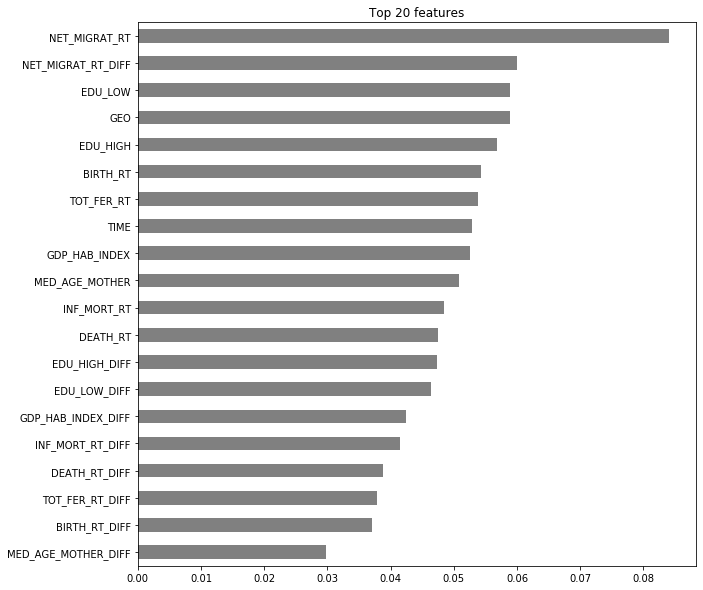

In [0]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

## Drop-Column Importance

In [0]:
column  = 'NET_MIGRAT_RT'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without NET_MIGRAT_RT: 0.5378729915837797
Validation Accuracy with NET_MIGRAT_RT: 0.5539403213465952
Drop-Column Importance for NET_MIGRAT_RT: 0.016067329762815552


In [0]:
column  = 'TIME'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without TIME: 0.5371078806426932
Drop-Column Importance for TIME: 0.016832440703901996


In [0]:
column  = 'MED_AGE_MOTHER'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without MED_AGE_MOTHER: 0.5723029839326702
Drop-Column Importance for MED_AGE_MOTHER: -0.018362662586074996


## Permutation Importance

In [0]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

In [0]:
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
!pip install eli5

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

# 1. Calculate permutation importances
permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [0]:
feature_names = X_val.columns.tolist()
# pd.Series(permuter.feature_importances_, feature_names).sort_values()

# 2. Display permutation importances
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.0398 ± 0.0261,NET_MIGRAT_RT
0.0162 ± 0.0053,BIRTH_RT
0.0057 ± 0.0058,MED_AGE_MOTHER_DIFF
0.0055 ± 0.0108,NET_MIGRAT_RT_DIFF
0.0049 ± 0.0148,GDP_HAB_INDEX
0.0021 ± 0.0149,INF_MORT_RT
0.0002 ± 0.0121,DEATH_RT_DIFF
0 ± 0.0000,TIME
-0.0005 ± 0.0085,TOT_FER_RT_DIFF
-0.0015 ± 0.0046,EDU_LOW_DIFF


## Feature selection

In [0]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

In [0]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.5592960979342004


In [0]:
permuter.feature_importances_ - permuter.feature_importances_std_ > 0

array([False, False, False, False,  True,  True, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False])

## Gradient Boosting

In [0]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
      

In [0]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.6097934200459066


In [0]:
# fit_transfom on train, transform on val
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators=1000,  
    max_depth=5,       
    learning_rate=0.4,  
    min_child_weight=0.4,  
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', 
          early_stopping_rounds=50) 

[0]	validation_0-error:0.358278	validation_1-error:0.377965
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.345945	validation_1-error:0.393267
[2]	validation_0-error:0.327132	validation_1-error:0.409334
[3]	validation_0-error:0.328177	validation_1-error:0.394032
[4]	validation_0-error:0.308528	validation_1-error:0.413925
[5]	validation_0-error:0.296823	validation_1-error:0.403979
[6]	validation_0-error:0.284699	validation_1-error:0.420811
[7]	validation_0-error:0.283236	validation_1-error:0.420046
[8]	validation_0-error:0.2801	validation_1-error:0.41469
[9]	validation_0-error:0.276965	validation_1-error:0.415455
[10]	validation_0-error:0.269649	validation_1-error:0.408569
[11]	validation_0-error:0.265468	validation_1-error:0.410099
[12]	validation_0-error:0.252508	validation_1-error:0.407804
[13]	validation_0-error:0.242475	validation_1-error:0.40091

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.4, max_delta_step=0, max_depth=5,
              min_child_weight=0.4, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

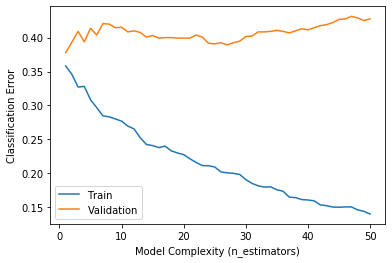

In [0]:
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
# plt.ylim((0.35, 0.45)) # Zoom in
plt.legend();

## Partial Dependence Plot

In [0]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
!pip install pdpbox

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'BIRTH_RT'
# feature = 'MED_AGE_MOTHER_DIFF'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


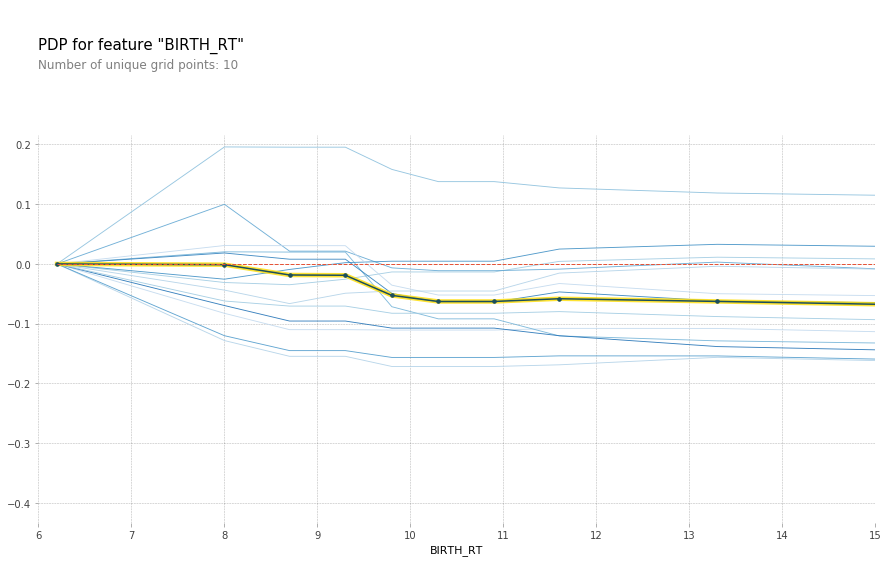

In [0]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, 
         frac_to_plot=0.01)
plt.xlim((6,15));

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [0]:
features = ['BIRTH_RT', 'MED_AGE_MOTHER_DIFF']

interaction = pdp_interact(
    model=pipeline, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


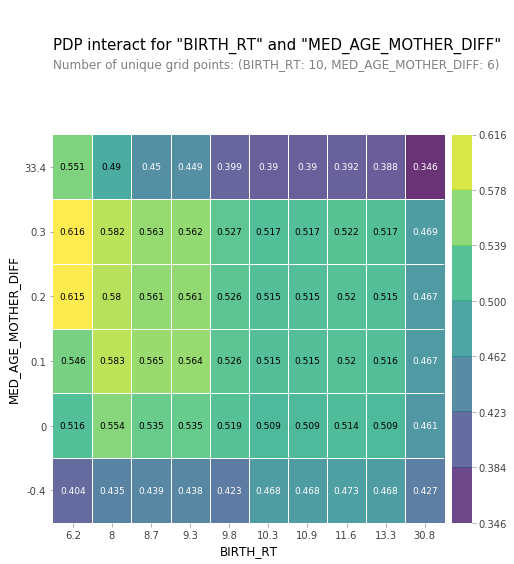

In [0]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

## Shapley Value Plots

In [0]:
row = X_test.iloc[[30]]
row

,TIME,GEO,MED_AGE_MOTHER,TOT_FER_RT,NET_MIGRAT_RT,BIRTH_RT,DEATH_RT,INF_MORT_RT,GDP_HAB_INDEX,EDU_LOW,EDU_HIGH,MED_AGE_MOTHER_DIFF,TOT_FER_RT_DIFF,NET_MIGRAT_RT_DIFF,BIRTH_RT_DIFF,DEATH_RT_DIFF,INF_MORT_RT_DIFF,GDP_HAB_INDEX_DIFF,EDU_LOW_DIFF,EDU_HIGH_DIFF
556,2016,BG31,26.7,1.73,-6.7,8.1,19.7,9.3,14,24.2,19.1,0.1,0.02,-1.8,0.0,-0.2,1.5,1.0,2.3,-3.4


In [0]:
!pip install shap

     |████████████████████████████████| 266kB 8.8MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383175 sha256=aaa9fd850b13faef52dc48a8acf10bc9cc954c8e0630faafac1296f30532c5ca
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


In [0]:
# Arrange data into X features matrix and y target vector
target = 'MIG_CHANGE'
features = train.columns.drop([target, 'GEO_LABEL'])

X_train = train[features]
X_val = val[features]
X_test = test[features]

y_train = train[target]
y_val = val[target]
y_test = test[target]

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='error', 
          early_stopping_rounds=10)

[0]	validation_0-error:0.40949	validation_1-error:0.521041
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.38587	validation_1-error:0.421576
[2]	validation_0-error:0.385661	validation_1-error:0.424637
[3]	validation_0-error:0.371865	validation_1-error:0.443764
[4]	validation_0-error:0.360786	validation_1-error:0.413925
[5]	validation_0-error:0.358905	validation_1-error:0.415455
[6]	validation_0-error:0.34699	validation_1-error:0.412395
[7]	validation_0-error:0.352007	validation_1-error:0.417751
[8]	validation_0-error:0.348244	validation_1-error:0.41163
[9]	validation_0-error:0.352634	validation_1-error:0.41163
[10]	validation_0-error:0.345945	validation_1-error:0.406274
[11]	validation_0-error:0.348453	validation_1-error:0.404744
[12]	validation_0-error:0.342182	validation_1-error:0.417751
[13]	validation_0-error:0.344482	validation_1-error:0.41163
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

In [0]:
def explain(row_number):
    positive_class = 'YES'
    positive_class_index = 1

    # Get & process the data for the row
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)

    # Make predictions (includes predicted probability)
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # Show prediction & probability
    print(f'The model predicts MIG_CHANGE is {pred}, with {pred_proba:.0f}% probability.')
    
    # Get shapley additive explanations
    shap_values = explainer.shap_values(row_processed)

    # Get top 3 "pros & cons" for fully paid
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # Show top 3 reason for prediction
    print('\n')
    print('Top 3 reasons for prediction:')
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} is {feature_value}.')

    # Show top 1 counter-argument against prediction
    print('\n')
    print('Top counter-argument against prediction:')
    evidence = cons if pred == positive_class else pros
    feature_name, feature_value = evidence[0]
    print(f'- {feature_name} is {feature_value}.')

    # Show Shapley Values Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit' # For classification, this shows predicted probabilities
    )

explain(30)

The model predicts MIG_CHANGE is YES, with 72% probability.


Top 3 reasons for prediction:
1. NET_MIGRAT_RT is -6.7.
2. TIME is 2016.
3. BIRTH_RT is 8.1.


Top counter-argument against prediction:
- GDP_HAB_INDEX is 14.
